<a href="https://colab.research.google.com/github/smurli/Stocker/blob/master/Stock_Trade_Prediction_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages and tools

In [1]:
!git clone https://github.com/smurli/Stocker.git Stocker
!pip install -U pytrends


fatal: destination path 'Stocker' already exists and is not an empty directory.
Requirement already up-to-date: pytrends in /usr/local/lib/python3.6/dist-packages (4.4.0)


# Imports and Hyper Parameters

In [0]:
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#Hyper Parameters

##Stock Ticker
#STOCK_TICKER = "ASIANPAINT.NS"
#STOCK_TICKER = "TATAMOTORS.NS"
STOCK_TICKER = "RELIANCE.NS"

##Compare predictions of stock price starting from this year.
VALIDATE_FROM_YEAR = 2018
TRAIN_FROM = pd.to_datetime('2014/01/01', format='%Y/%m/%d')
TEST_FROM = pd.to_datetime('2018/06/01', format='%Y/%m/%d')

##Number of max trading days, as a safety measure. No matter what trade possition is closed after these many days.
MAX_TRADING_DAYS = 45

## Trading BUY/SELL threshold
UPPER_THRESHOLD = 0.05
LOWER_THRESHOLD = 0.02



# Load Data Set

In [19]:
import quandl
from Stocker.stocker import Stocker

#Fetch stock prices for TICKER from yahoo
stock = Stocker(ticker = STOCK_TICKER, source='yahoo')
stock.stock.head()

RELIANCE.NS Stocker Initialized. Data covers 2001-01-01 to 2019-04-12.


,Date,High,Low,Open,Close,Volume,Adj Close,ds,Adj. Close,Adj. Open,y,Daily Change
0,2001-01-01,53.675701,52.949402,53.105499,53.378899,19259768.0,24.250788,2001-01-01,53.378899,53.105499,53.378899,0.273399
1,2001-01-02,56.073200,53.144600,53.160198,55.339100,42408935.0,25.141338,2001-01-02,55.339100,53.160198,55.339100,2.178902
2,2001-01-03,56.494900,55.136101,55.448399,56.237202,56622894.0,25.549358,2001-01-03,56.237202,55.448399,56.237202,0.788803
3,2001-01-04,57.307098,55.635899,56.088799,55.885799,38303310.0,25.389711,2001-01-04,55.885799,56.088799,55.885799,-0.202999
4,2001-01-05,57.291500,55.682701,55.682701,56.901001,47762434.0,25.850933,2001-01-05,56.901001,55.682701,56.901001,1.218300


Training Data Set:
Maximum Adj. Close = 996.30 on 2018-04-27.
Minimum Adj. Close = 399.98 on 2014-02-28.
Current Adj. Close = 1343.10 on 2019-04-12.



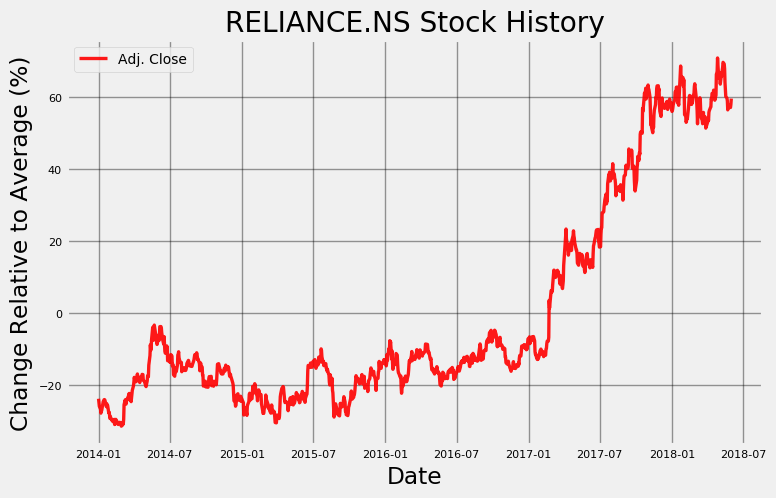

Test Data Set:
Maximum Adj. Close = 1391.85 on 2019-04-01.
Minimum Adj. Close = 930.55 on 2018-06-01.
Current Adj. Close = 1343.10 on 2019-04-12.



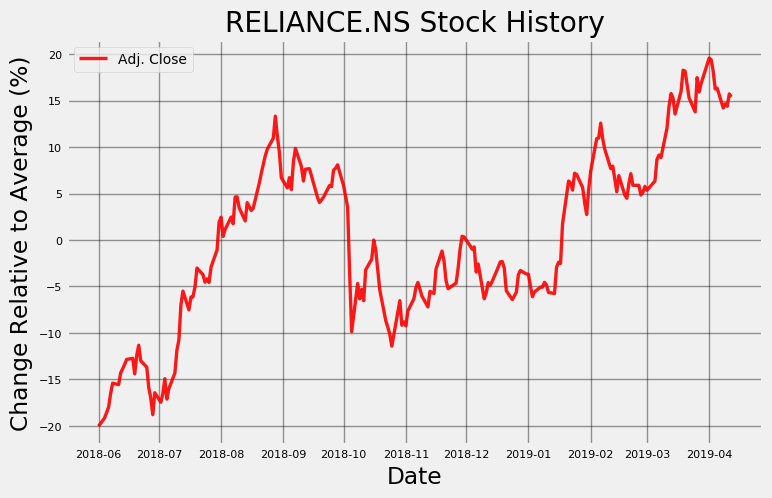

In [20]:
print("Training Data Set:")
stock.plot_stock(start_date = TRAIN_FROM, end_date = TEST_FROM, stats = ['Adj. Close'], plot_type='pct')
plt.show()

print("Test Data Set:")
stock.plot_stock(start_date = TEST_FROM, stats = ['Adj. Close'], plot_type='pct')
plt.show()


# Profit by long term investment

In [34]:
t1 = stock.stock.set_index("Date")
t1 = t1[t1.index >= TEST_FROM]
old = t1.iloc[0]["Adj Close"]
new = t1.iloc[-1]["Adj Close"]
print("Price at start of %s: %.2f, Price Today: %.2f " %(TEST_FROM.strftime('%Y/%m/%d'), old, new))
print("Profit %%: %.2f" % (((new-old)/old)*100))


Price at start of 2018/06/01: 924.85, Price Today: 1343.10 
Profit %: 45.22


# Evaluate Prediction


Prediction Range: 2018-04-12 to 2019-04-12.

Predicted price on 2019-04-11 = $1050.54.
Actual price on    2019-04-11 = $1346.80.

Average Absolute Error on Training Data = $12.81.
Average Absolute Error on Testing  Data = $155.55.

When the model predicted an increase, the price increased 49.63% of the time.
When the model predicted a  decrease, the price decreased  41.44% of the time.

The actual value was within the 80% confidence interval 54.66% of the time.


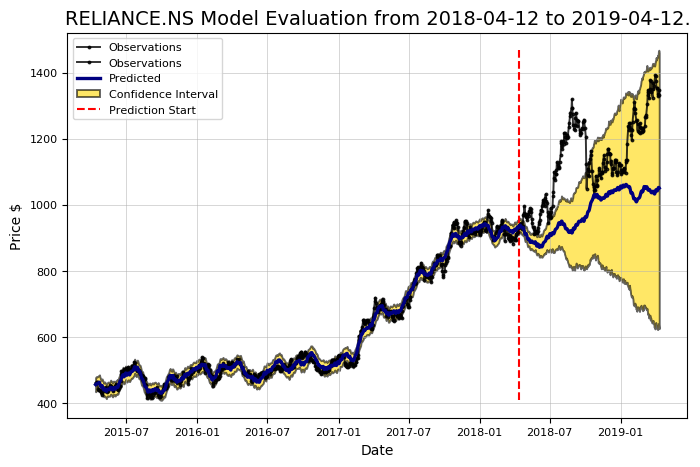

In [21]:
stock.max_date = max(stock.stock['Date'])
#--> stock.changepoint_prior_scale = 0.00010
stock.evaluate_prediction()


# Predict BUY & SELL

In [22]:
testData = stock.stock.set_index("Date")
testData = testData[testData.index >= TEST_FROM]

position = "CLOSE"
nofDays = 0

buy = []
sell = []


for index, row in tqdm_notebook(testData.iterrows(),total=testData.shape[0]):
    stock.max_date = index
    ret = stock.predict_future(days=MAX_TRADING_DAYS, plot=False)
    maxEstimate = ret.estimate.max()
    
    diff = (maxEstimate - row["Adj Close"])/row["Adj Close"]
    if position == "CLOSE":
        if diff >= UPPER_THRESHOLD:
            print (index, diff, "BUY")
            position = "OPEN"
            nofDays = 1
            buy.append(index)
    else:
        nofDays += 1
        if nofDays >= MAX_TRADING_DAYS:
            print (index, diff, "SELL", "MAX_DAYS")
            nofDays = 0
            position = "CLOSE"
            sell.append(index)
        if diff <= LOWER_THRESHOLD:
            print (index, diff, "SELL")
            nofDays = 0
            position = "CLOSE"
            sell.append(index)


2018-06-01 00:00:00 0.2305384856633543 BUY
2018-07-30 00:00:00 0.014176811579012384 SELL
2018-10-05 00:00:00 0.10346478503559059 BUY
2018-10-15 00:00:00 0.016125565428530778 SELL
2018-10-19 00:00:00 0.05623952501322332 BUY
2018-12-24 00:00:00 0.14958120689834714 SELL MAX_DAYS
2018-12-26 00:00:00 0.14433651079413098 BUY
2019-02-27 00:00:00 0.12004758951939341 SELL MAX_DAYS
2019-02-28 00:00:00 0.11317832047647752 BUY
2019-03-13 00:00:00 0.01773045940425017 SELL



In [23]:
def cumulativeProfit(data, buy, sell):
    total_pp = 0
    #for index, row in signal.iterrows():
    for i in range(0, len(buy)):    
        profit = data.loc[sell[i]].Close - data.loc[buy[i]].Close
        print("Buy on: {:%Y-%m-%d}, Sell on:{:%Y-%m-%d}, Profit: {:.2f}".format(buy[i], sell[i], profit))
        total_pp += profit/data.loc[buy[i]].Close
    return total_pp        


p = cumulativeProfit(testData, buy, sell)

print("Total Profit for %s from year %s: %.2f%%" % (STOCK_TICKER, TEST_FROM.strftime('%Y/%m/%d'), p*100))


Buy on: 2018-06-01, Sell on:2018-07-30, Profit: 220.85
Buy on: 2018-10-05, Sell on:2018-10-15, Profit: 90.90
Buy on: 2018-10-19, Sell on:2018-12-24, Profit: -12.15
Buy on: 2018-12-26, Sell on:2019-02-27, Profit: 125.15
Buy on: 2019-02-28, Sell on:2019-03-13, Profit: 116.25
Total Profit for RELIANCE.NS from year 2018/06/01: 52.13%
